In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import rasterio
import rioxarray
import xarray as xr
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score

In [2]:
from collections import Counter
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        img_size.append(img.shape)
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        if img.shape != size:
            img_path.remove(i)
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
    img_path_median = []
    for i in range(len(img_path_list)):
        if black_pixels[i] <= np.median(black_pixels):
            img_path_median.append(img_path_list[i])
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        if white_pixels[i] <= np.mean(white_pixels):
            img_path_mean_white.append(img_path_list[i])
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white



def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."
    

def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

def create_median_image(images_path):

    first_img = rioxarray.open_rasterio(images_path[0])

    width, height = first_img.data[0:3].transpose(1, 2, 0).shape[0:2]
    num_images = len(images_path)

    red_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    green_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    blue_values = np.zeros(( width,height, num_images), dtype=np.uint8)


    for i,j in enumerate(images_path):
        img = rioxarray.open_rasterio(j).data[0:3].transpose(1, 2, 0)
        try:
            red_values[:, :, i], green_values[:, :, i], blue_values[:, :, i] = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        except:
            pass
    
    red_median = np.median(red_values, axis=2)
    green_median = np.median(green_values, axis=2)
    blue_median = np.median(blue_values, axis=2)
    img_arr = np.uint8(np.dstack((red_median, green_median, blue_median)))
    median_image = Image.fromarray(img_arr)
    
    return img_arr, median_image


In [3]:
img_path = "/home/akansh-i2sc/Desktop/Study/detect-car-LR/data/bauhaus/**/*.tif"
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

Initial size of dataset 833
Most common size of the dataset (4, 158, 169)
Final size of dataset(after removing faulty size images) 819
Final size of dataset(after removing faulty black pixels in images) 713
Final size of dataset(after removing faulty white pixels in images) 635


In [5]:
df = label_csv(clean_3)
df.head()

Class distribution in dataset: 0    553
1     82
Name: label, dtype: int64


,image_path,day,label
0,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Tuesday,0
1,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Sunday,1
2,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Thursday,0
3,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Saturday,0
4,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Tuesday,0


In [6]:
median_image, _ = create_median_image(glob.glob(img_path, recursive=True))

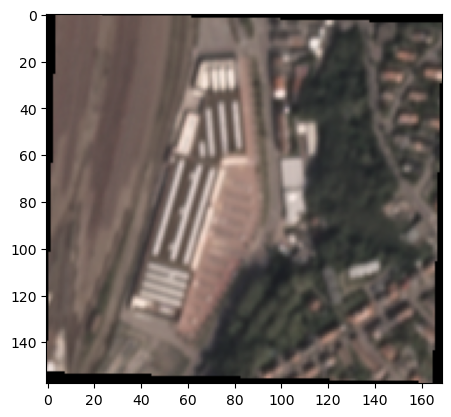

In [8]:
plt.imshow(median_image)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable
from torch import nn, Tensor
import torch
from torch.nn import functional as F
from typing import List, Any, Dict, Tuple
from abc import abstractmethod
from typing import Any

In [62]:
### Pytorch custom dataset class
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class VAE_dataset(Dataset):
    def __init__(self, df, median_img, transform=None):
        self.df = df
        self.median_img = median_img
        self.transform = transform
        self.median_img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Resize((128, 128)),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
            #                      std=[0.229, 0.224, 0.225]) #Experiment with adding noise here
        ])

    def __getitem__(self, idx):
        img_path = self.df.image_path.values[idx]
        img_1 = rioxarray.open_rasterio(img_path)
        img_1 = img_1.data[0:3].transpose(1, 2, 0)
        label = self.df.label.values[idx]
        img_2 = self.median_img_transform(self.median_img)

        if self.transform:
            img_1 = self.transform(img_1)
            # img_2 = self.transform(img_2) #median image augmentation, need experiments here. 
        return img_1, img_2, label

    def __len__(self):
        return len(self.df)

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
from tqdm.auto import tqdm
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#train test split
train, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df.label.values)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())

cuda:0
Train size: (571, 3)
Test size: (64, 3)
Train class distribution: 0    497
1     74
Name: label, dtype: int64
Test class distribution: 0    56
1     8
Name: label, dtype: int64


In [67]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.RandomVerticalFlip(p=0.2),
    # transforms.RandomRotation(degrees=30),
    # transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),

    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225]),
])


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),

    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225]),
])


train_dataset = VAE_dataset(train,median_image, transform=train_transform)
test_dataset = VAE_dataset(test, median_image, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [68]:
for x1,x2,y in train_loader:
    print(x1.shape)
    print(x2.shape)
    print(y.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32])


In [69]:
# class AddNoise(object):
#     def __init__(self, noise_level=0.05):
#         self.noise_level = noise_level

#     def __call__(self, x):
#         noise = torch.randn_like(x) * self.noise_level
#         return x + noise

In [70]:
# Define the U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [71]:
criterion = nn.MSELoss()
unet = UNet()
unet = unet.to(device)
optimizer = optim.Adam(unet.parameters(), lr=1e-3)

In [72]:
# Training loop
num_epochs = 10
best_test_loss = float('inf') 

for epoch in range(num_epochs):
    for batch_idx, (x1,x2,y) in tqdm(enumerate(train_loader)):
        x1 = Variable(x1).to(device)
        x2 = Variable(x2).to(device)
        optimizer.zero_grad()
        output = unet(x1)
        loss = criterion(output, x2)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Epoch {} Batch {}: Loss: {:.6f}'.format(epoch, batch_idx, loss.item()))


    # Testing loop
    test_loss = 0.0
    with torch.no_grad():
        for x1,x2,y in test_loader:
            x1 = Variable(x1).to(device)
            x2 = Variable(x2).to(device)
            test_output = unet(x1)
            test_loss += criterion(test_output, x2).item()

    test_loss /= len(test_loader.dataset)

    print('Epoch {}: Test Loss: {:.6f}'.format(epoch, test_loss))

    # Save the model if it has the lowest test loss so far
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(unet.state_dict(), 'best_unet.pth')

0it [00:00, ?it/s]

Epoch 0 Batch 0: Loss: 0.125272
Epoch 0: Test Loss: 0.001720


0it [00:00, ?it/s]

Epoch 1 Batch 0: Loss: 0.055312
Epoch 1: Test Loss: 0.001677


0it [00:00, ?it/s]

Epoch 2 Batch 0: Loss: 0.055038
Epoch 2: Test Loss: 0.001647


0it [00:00, ?it/s]

Epoch 3 Batch 0: Loss: 0.054768
Epoch 3: Test Loss: 0.001623


0it [00:00, ?it/s]

Epoch 4 Batch 0: Loss: 0.051896
Epoch 4: Test Loss: 0.001607


0it [00:00, ?it/s]

Epoch 5 Batch 0: Loss: 0.051689
Epoch 5: Test Loss: 0.001616


0it [00:00, ?it/s]

Epoch 6 Batch 0: Loss: 0.052581
Epoch 6: Test Loss: 0.001592


0it [00:00, ?it/s]

Epoch 7 Batch 0: Loss: 0.051702
Epoch 7: Test Loss: 0.001589


0it [00:00, ?it/s]

Epoch 8 Batch 0: Loss: 0.050472
Epoch 8: Test Loss: 0.001589


0it [00:00, ?it/s]

Epoch 9 Batch 0: Loss: 0.050615
Epoch 9: Test Loss: 0.001585


In [73]:
criterion(unet(x1), x2)

tensor(0.0508, device='cuda:0', grad_fn=<MseLossBackward0>)

In [74]:
criterion(x1, x2)

tensor(0.0083, device='cuda:0')